<a href="https://colab.research.google.com/github/zhaoxiangmax/QCIF__R_CC/blob/main/notebooks/EC_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/notebooks_banner_withframe.png)


# Species Distribution Analysis - Genralised Linear Model (GLM)


---
Author details: Abhimanyu Raj Singh and Xiang Zhao

Editor details: Dr Sebastian Lopez Marcano

Contact details: support@ecocommons.org.au

Copyright statement: This script is the product of the EcoCommons platform.   
                     Please refer to the EcoCommons website for more details:   <https://www.ecocommons.org.au/>  

Date: Oct 2024  

---

#### Script and data info:

This notebook, developed by the EcoCommons team, showcases how to run a Species Distribution Model (SDM) using a Generalized Linear Model (GLM) to predict species presence. The model focuses on the **koala** ***(Phascolarctos cinereus)*** presences and absences based on environmental data.This species is near thretened and more information is avaible here https://apps.des.qld.gov.au/species-search/details/?id=921

**Workflow Overview**:

- Initial Setup:
        Set the working directory and load necessary R packages (dismo, ggplot2, raster, googledrive, sp, dplyr, terra).
        Create directories to store raw data files.

- Data Download:
        Download koala **(*Phascolarctos cinereus*)** occurrence data and stacked environmental layers from Google Drive which has been collected from **ALA** and open climate data portal.

- Data Processing:
        Load and prepare the koala data by ensuring correct data types and handling missing values.

- Modeling and Prediction:
        Apply a GLM to predictkoala presence based on environmental variables.
        Make predictions for the whole Australia.

- Outcome:
        The model's predictions will be compared to observed presence data, and the results are evaluated using performance metrics like AUC (Area Under the Curve).
        Visualizations and maps will showcase predicted distributions of tree kangaroos under current and forecast conditions.

In the near future, this material may form part of comprehensive support materials available to EcoCommons users.

If you have any corrections or suggestions to improve the effeciengy, please [contact the EcoCommons](mailto:support@ecocommons.org.au) team.


![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/EC_section_break.png)



### Examplary Species: Koala (<em>Phascolarctos cinereus</em>)

<div style="display: flex; align-items: flex-start;">
<img src="https://drive.google.com/uc?export=view&id=17xBcI0neycOZRN2D4T137f_jWK2aAZrG" alt="Image Description" width="256" style="margin-right: 20px;">
<div>
        <h3>Summary</h3>
        <p>
            The koala (Phascolarctos cinereus), sometimes called the koala bear, is an arboreal herbivorous marsupial native to Australia. It is the only extant representative of the family Phascolarctidae. Its closest living relatives are the wombats. The koala is found in coastal areas of the island's eastern and southern regions, inhabiting Queensland, New South Wales, Victoria, and South Australia. It is easily recognisable by its stout, tailless body and large head with round, fluffy ears and large, dark nose. The koala has a body length of 60–85 cm (24–33 in) and weighs 4–15 kg (8.8–33.1 lb). Fur colour ranges from silver grey to chocolate brown. Koalas from the northern populations are typically smaller and lighter in colour than their counterparts further south. These populations possibly are separate subspecies, but this is disputed.
            (Source: <a href="https://bie.ala.org.au/species/https://biodiversity.org.au/afd/taxa/e9d6fbbd-1505-4073-990a-dc66c930dad6" target="_blank">ALA Australia</a>)
        </p>
    </div>
</div>


# A. Environment, Packages and Dependencies

Some house-keeping before we start. This process might take some time (30mins) as many packages needed to be installed.

## 1. Set working directory and make a folder to store data.

In [ ]:
# Set Workspace as the current working directory
workspace <- getwd()

raw_data_dir <- file.path(workspace, "raw_data")

# Create the 'raw_data' directory if it doesn't exist
if (!dir.exists(raw_data_dir)) {
  dir.create(raw_data_dir, recursive = TRUE)
  cat("Directory 'raw_data' created successfully.\n")
} else {
  cat("Directory 'raw_data' already exists.\n")
}

# Increase the plot size by changing the options for the plot dimensions
options(repr.plot.width = 16, repr.plot.height = 8)  # This will make the plot larger in the notebook output


Directory 'raw_data' already exists.


## 2. Install and load essential libraries.

In [ ]:
# List of packages to check, install if needed, and load
packages <- c("dplyr", "terra", "sf", "googledrive", "ggplot2", "corrplot", "pROC")

# Install missing packages and load them
for (pkg in packages) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    install.packages(pkg)
  }
  library(pkg, character.only = TRUE)
}

# B. Data

## 1. Get data from EcoCommons Public Google drive

In [ ]:
library(googledrive)

# De-authenticate Google Drive to access public files
drive_deauth()

# Define Google Drive file IDs and corresponding local file paths for environmental variables
file_ids <- list(
  csv = "13wnlQvnAqtml-_MUY6iIZe7LabrrhQCX", # Koala data
  env_var_stack = "1ES0UbTDKSKyQ7PpM8eFN59R8xOYuDgrC" # environmental variables
)

# Define local file paths for each environmental variable
file_paths <- list(
  csv = file.path(workspace, "raw_data", "koala.csv"),
  env_var_stack = file.path(workspace, "raw_data", "env_var_stack.tif")
)

# Function to download individual files with progress messages
download_file <- function(file_id, file_path) {
  cat("Downloading:", basename(file_path), "...\n")
  drive_download(as_id(file_id), path = file_path, overwrite = TRUE)
  cat("Downloaded:", basename(file_path), "\n")
}

# Download each environmental variable file
cat("Downloading environmental variable files...\n")
invisible(mapply(download_file, file_ids, file_paths))

# Confirm the files have been downloaded
downloaded_files <- list.files(file.path(workspace, "raw_data"), recursive = TRUE)
cat("Downloaded files:\n", downloaded_files, "\n")


Downloading: koala.csv ...


File downloaded:

• koala_ala.csv <id: 13wnlQvnAqtml-_MUY6iIZe7LabrrhQCX>

Saved locally as:

• /content/raw_data/koala.csv



Downloaded: koala.csv 
Downloading: env_var_stack.tif ...


File downloaded:

• stacked_env_raster.tif <id: 1ES0UbTDKSKyQ7PpM8eFN59R8xOYuDgrC>

Saved locally as:

• /content/raw_data/env_var_stack.tif



Downloaded: env_var_stack.tif 
Downloaded files:
 aus_shapefile/AUS_2021_AUST_GDA2020.dbf aus_shapefile/AUS_2021_AUST_GDA2020.prj aus_shapefile/AUS_2021_AUST_GDA2020.shp aus_shapefile/AUS_2021_AUST_GDA2020.shx aus_shapefile/AUS_2021_AUST_GDA2020.xml env_var_stack.tif koala.csv 


In [ ]:
library(googledrive)

# De-authenticate Google Drive to access public files
drive_deauth()

# Folder ID for the Australian polygon shapefile
aus_folder_id <- "1rzNHthnQQXVulocKkB5i7v2dObqKMP11"

# Define the local directory to save the shapefile components
shapefile_dir <- file.path(workspace, "raw_data", "aus_shapefile")
dir.create(shapefile_dir, showWarnings = FALSE, recursive = TRUE)

# List all files in the shapefile folder on Google Drive
files_in_folder <- drive_ls(as_id(aus_folder_id))

# Download each file in the folder
cat("Downloading shapefile components...\n")
for (i in 1:nrow(files_in_folder)) {
  file_name <- files_in_folder$name[i]
  cat("Downloading:", file_name, "...\n")
  drive_download(files_in_folder$id[i], path = file.path(shapefile_dir, file_name), overwrite = TRUE)
}

cat("Shapefile components downloaded to:", shapefile_dir, "\n")


Downloading: AUS_2021_AUST_GDA2020.xml ...


File downloaded:

• AUS_2021_AUST_GDA2020.xml <id: 1BxMyIxENdWJ2RiZxK_8Ay_0r2Uvad5Wd>

Saved locally as:

• /content/raw_data/aus_shapefile/AUS_2021_AUST_GDA2020.xml



Downloading: AUS_2021_AUST_GDA2020.shx ...


File downloaded:

• AUS_2021_AUST_GDA2020.shx <id: 1wfSxFsmgK4V44f4ZJhYy3V6wL16YpVWe>

Saved locally as:

• /content/raw_data/aus_shapefile/AUS_2021_AUST_GDA2020.shx



Downloading: AUS_2021_AUST_GDA2020.dbf ...


File downloaded:

• AUS_2021_AUST_GDA2020.dbf <id: 1gdWxQ5aOB_KuejlHn254K7RwdtDR2N8f>

Saved locally as:

• /content/raw_data/aus_shapefile/AUS_2021_AUST_GDA2020.dbf



Downloading: AUS_2021_AUST_GDA2020.prj ...


File downloaded:

• AUS_2021_AUST_GDA2020.prj <id: 1Fi9K9mWOpvksSkH0CGJN9XlKf8-1LjSj>

Saved locally as:

• /content/raw_data/aus_shapefile/AUS_2021_AUST_GDA2020.prj



Downloading: AUS_2021_AUST_GDA2020.shp ...


File downloaded:

• AUS_2021_AUST_GDA2020.shp <id: 1ZWGQYHbygM-MCFyON76FXwj7uHwJnpxH>

Saved locally as:

• /content/raw_data/aus_shapefile/AUS_2021_AUST_GDA2020.shp



Shapefile components downloaded to: /content/raw_data/aus_shapefile 


## 2. Define Study Area

Reading layer `AUS_2021_AUST_GDA2020' from data source 
  `/content/raw_data/aus_shapefile/AUS_2021_AUST_GDA2020.shp' 
  using driver `ESRI Shapefile'
replacing null geometries with empty geometries
Simple feature collection with 2 features and 6 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 96.81695 ymin: -43.7405 xmax: 167.998 ymax: -9.142163
Geodetic CRS:  GDA2020


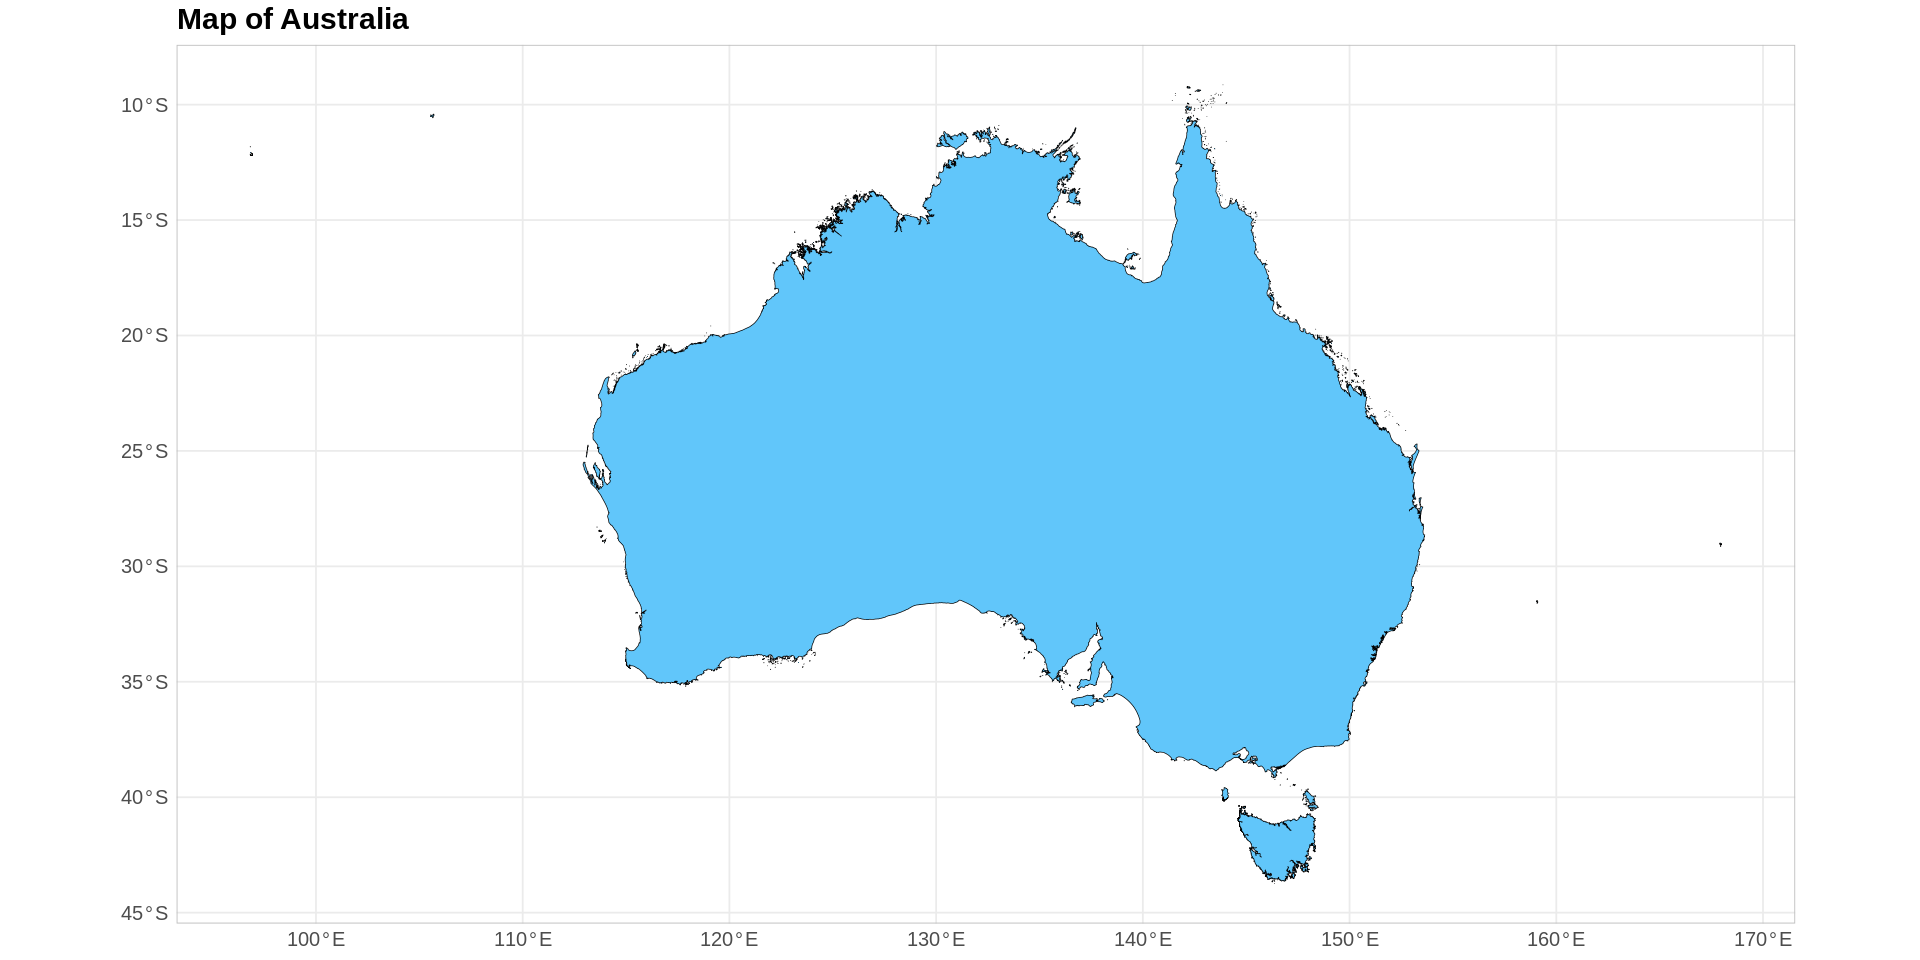

In [ ]:
library(sf)
library(terra)
library(ggplot2)

# Define the path to the Australian shapefile's .shp component
shapefile_path <- file.path(workspace, "raw_data", "aus_shapefile", "AUS_2021_AUST_GDA2020.shp")

# Load the Australian boundary as an sf object and convert to EPSG 4326
australia_boundary <- st_read(shapefile_path)
australia_boundary <- st_transform(australia_boundary, crs = 4326)

# Convert the sf object to a SpatVector for terra operations, if needed
australia_boundary_vect <- vect(australia_boundary)

# Plot the Australia boundary using ggplot2
ggplot(data = australia_boundary) +
  geom_sf(fill = "#61c6fa", color = "black") +  # Fill with light blue and outline in black
  labs(title = "Map of Australia") +
  theme_minimal() +
  theme(plot.title = element_text(size = 18, face = "bold"),
        axis.title.x = element_text(size = 12),
        axis.title.y = element_text(size = 12),
        axis.text.x = element_text(size = 12),
        axis.text.y = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        panel.border = element_rect(colour = "gray", fill = NA, linewidth = 0.5))


## 3. Species Occurrence Data Prep and check

In [ ]:
# Load required libraries
library(sf)
library(dplyr)

# Read the koala data
koala_path <- file.path(workspace, "raw_data", "koala.csv")
koala_data <- read.csv(koala_path)

# Filter rows without missing values in coordinates
koala_data_clean <- koala_data %>%
  filter(!is.na(decimalLongitude), !is.na(decimalLatitude))

# Convert the koala data to an sf object using "decimalLongitude" and "decimalLatitude"
koala_sf <- st_as_sf(koala_data_clean, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)

# Define the bounding box
bbox <- st_bbox(c(xmin = 96.81695, ymin = -43.7405, xmax = 167.998, ymax = -9.142163), crs = st_crs(koala_sf))

# Convert the bbox to an sfc object
bbox_sfc <- st_as_sfc(bbox)

# Filter koala points that fall within the bounding box
koala_sf_au <- koala_sf[st_within(koala_sf, bbox_sfc, sparse = FALSE), ]

# View filtered points
print(koala_sf_au)

# Replace "PRESENT" with 1 and "ABSENT" with 0 in the occurrenceStatus column
koala_sf_au$occurrenceStatus <- ifelse(koala_sf_au$occurrenceStatus == "PRESENT", 1, 0)

# Convert occurrenceStatus to a factor
koala_sf_au$occurrenceStatus <- factor(koala_sf_au$occurrenceStatus, levels = c(0, 1))

# View updated koala data
print(koala_sf_au)


Simple feature collection with 244474 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 115.6839 ymin: -39.1295 xmax: 154 ymax: -15.4
Geodetic CRS:  WGS 84
First 10 features:
   occurrenceStatus                   geometry
1           PRESENT POINT (138.7069 -34.91539)
2           PRESENT POINT (138.8452 -35.19909)
3           PRESENT POINT (138.7268 -34.91561)
4           PRESENT POINT (138.7688 -34.96979)
5           PRESENT POINT (138.6979 -34.96306)
6           PRESENT POINT (138.7317 -34.92928)
7           PRESENT POINT (138.5654 -34.93541)
8           PRESENT POINT (138.6774 -35.02592)
9           PRESENT  POINT (138.7089 -34.9585)
10           ABSENT  POINT (138.6245 -34.9807)
Simple feature collection with 244474 features and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 115.6839 ymin: -39.1295 xmax: 154 ymax: -15.4
Geodetic CRS:  WGS 84
First 10 features:
   occurrenceStatus                   geometry
1                 1 POIN

In [ ]:
library(ggplot2)
library(dplyr)

# Calculate counts for presence and absence
koala_counts <- koala_sf_au %>%
  dplyr::count(occurrenceStatus)

# Create labels for the legend that include counts
legend_labels <- c(
  "0" = paste0("ABSENT: ", koala_counts$n[koala_counts$occurrenceStatus == 0]),
  "1" = paste0("PRESENT: ", koala_counts$n[koala_counts$occurrenceStatus == 1])
)


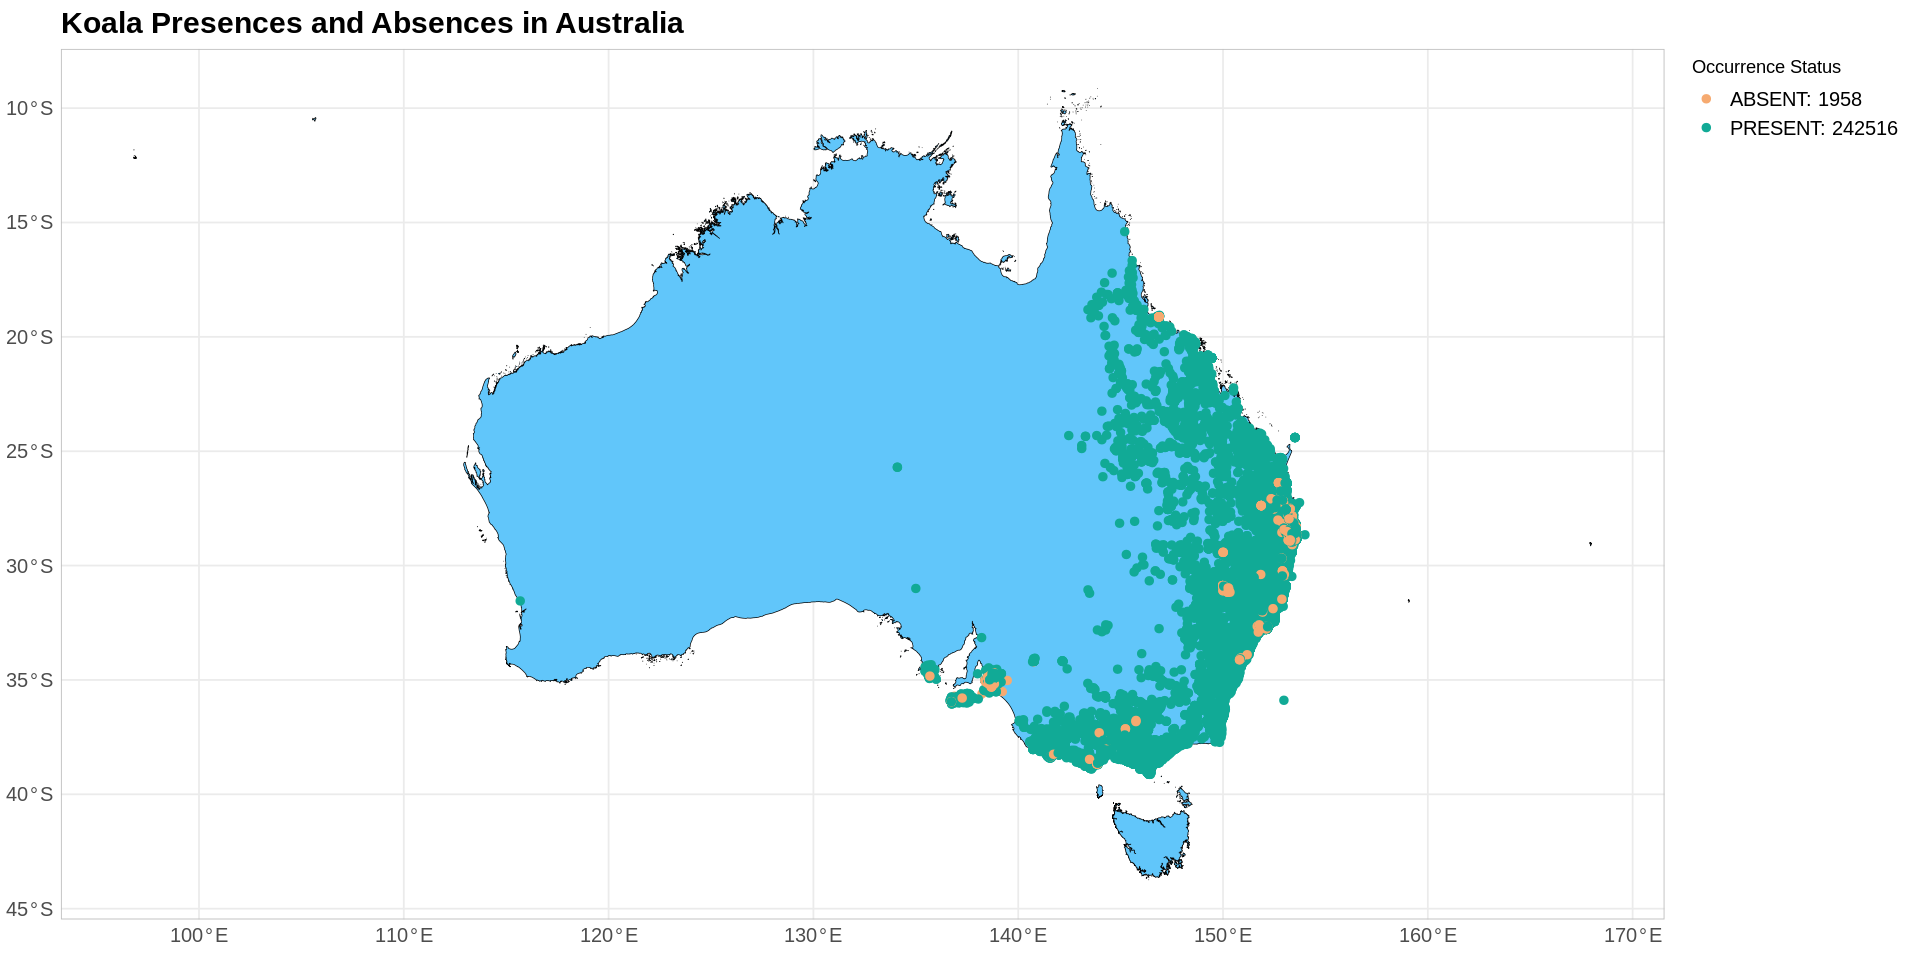

In [ ]:
# Plotting
ggplot(data = australia_boundary) +
  geom_sf(fill = "#61c6fa", color = "black") +  # Australia map fill and outline color
  geom_sf(data = koala_sf_au, aes(color = occurrenceStatus), size = 2) +  # Koala presences and absences points
  scale_color_manual(values = c("0" = "#f6aa70", "1" = "#11aa96"),  # Colors for absence (0) and presence (1)
                     labels = legend_labels) +  # Labels for legend including counts
  labs(title = "Koala Presences and Absences in Australia", color = "Occurrence Status") +  # Title and legend title
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.border = element_rect(colour = "gray", fill = NA, linewidth = 0.5),
    legend.position.inside = c(0.8, 0.2),  # Adjusted legend position for full map
    legend.justification = c(0, 1)
  )

## 4. Environmental Variables Prep and check

Since the extents of the enviromental variables 1 to 5 are world wide, we need to crop it to the extent of our study area, that is Australia. And we want to make sure the coordinate system of each of the variable is EPSG:4326.

In [ ]:
raster_stack <- rast(stack_file_path)

print(names(raster_stack))

[1] "env_var_1" "env_var_2" "env_var_3" "env_var_4" "env_var_5" "Category" 


In [ ]:
library(terra)

# Load the raster stack
stack_file_path <- file.path(workspace, "raw_data", "env_var_stack.tif")
raster_stack <- rast(stack_file_path)

# Assign new names to the first five layers
layer_names <- c(
  "env_var_1", #   "Bioclim 01: Annual Mean Temperature",
  "env_var_2", #   "Bioclim 02: Mean Diurnal Range",
  "env_var_3", #   "Bioclim 03: Isothermality",
  "env_var_4", #   "Bioclim 04: Temperature Seasonality",
  "env_var_5", #   "Bioclim 05: ",
  "env_cat_var_1" # "Six class of land use of Australia",
)

names(raster_stack)[1:6] <- layer_names

# Factorize the sixth raster layer
raster_stack[[6]] <- as.factor(raster_stack[[6]])

# Verify the names
print(raster_stack)



class       : SpatRaster 
dimensions  : 14113, 22774, 6  (nrow, ncol, nlyr)
resolution  : 0.002451532, 0.002451532  (x, y)
extent      : 105.7046, 161.5358, -43.74011, -9.141636  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
sources     : env_var_stack.tif  (5 layers) 
              env_var_stack.tif  
names       : env_var_1, env_var_2, env_var_3, env_var_4, env_var_5, env_c~var_1 
min values  :  4.272866,  3.591667,  31.50585,  53.13949,  15.60910,           1 
max values  : 29.350683, 17.464588,  77.26542, 682.58344,  42.34991,           6 


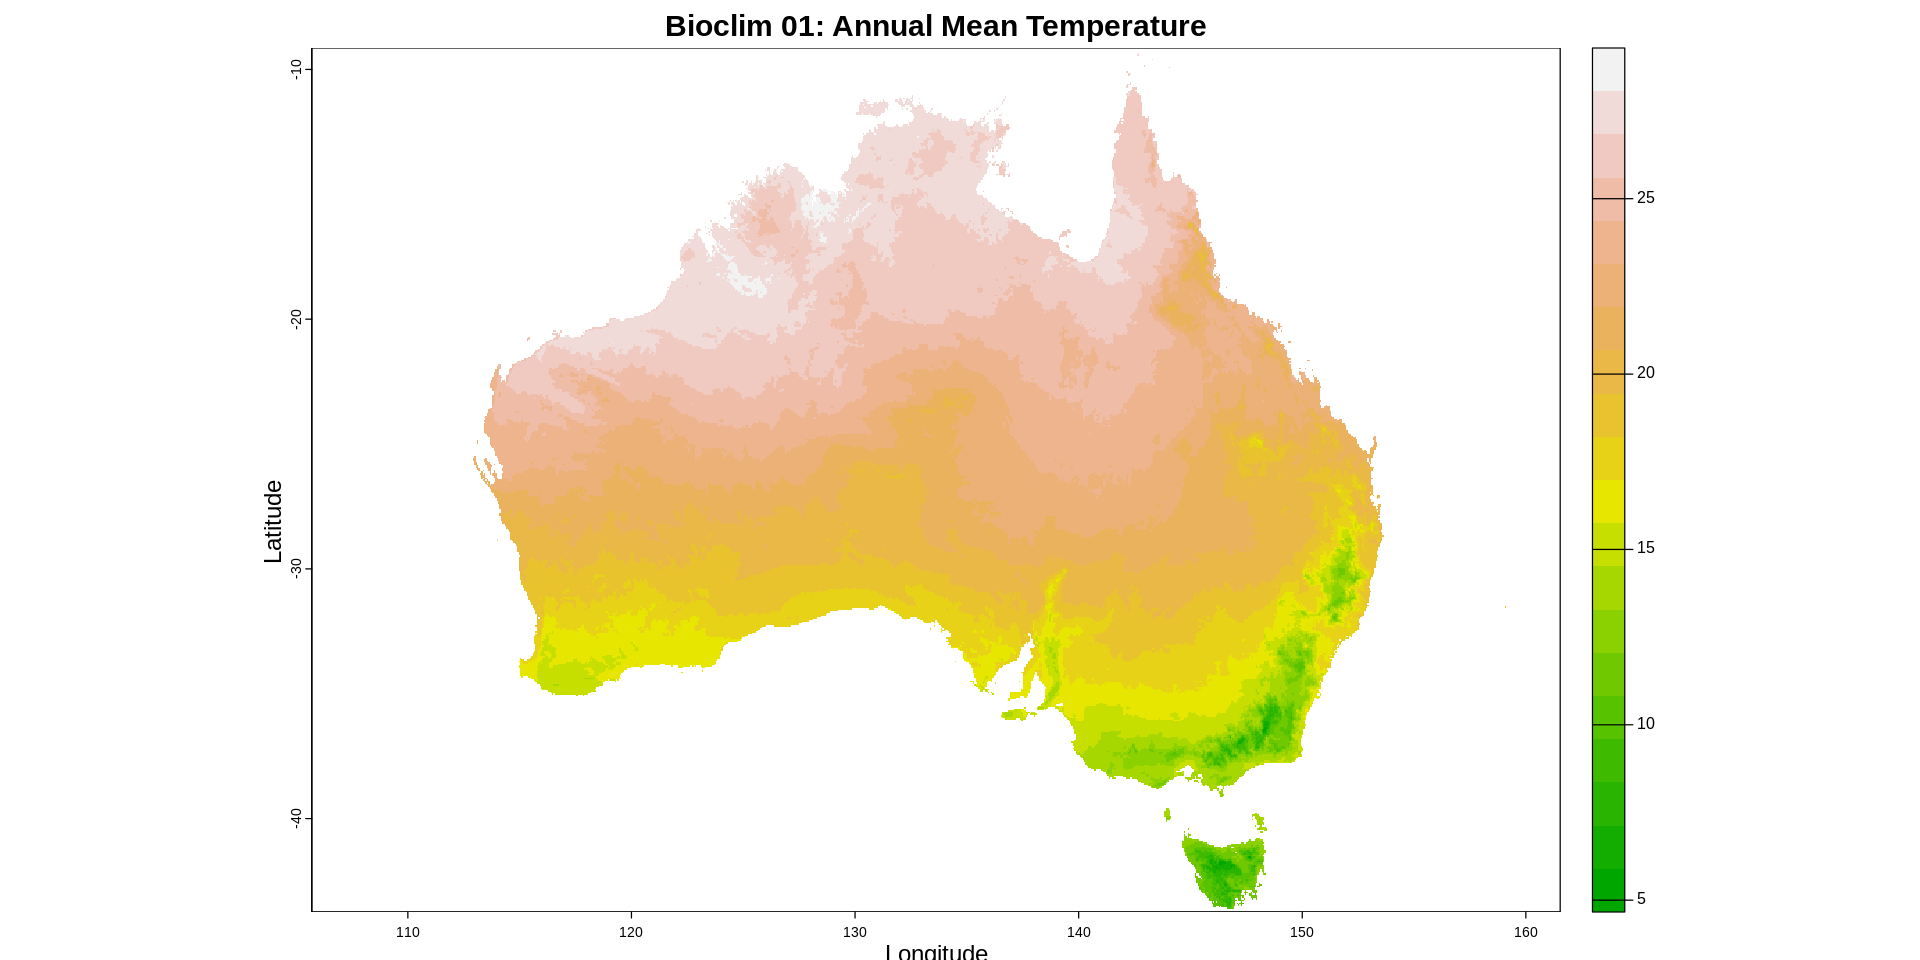

In [ ]:
# Plot the masked raster
plot(raster_stack[[1]],
     main = "Bioclim 01: Annual Mean Temperature",
     col = terrain.colors(20),
     xlab = "Longitude",
     ylab = "Latitude",
     cex.main = 1.5,
     cex.lab = 1.2,
     cex.axis = 1)


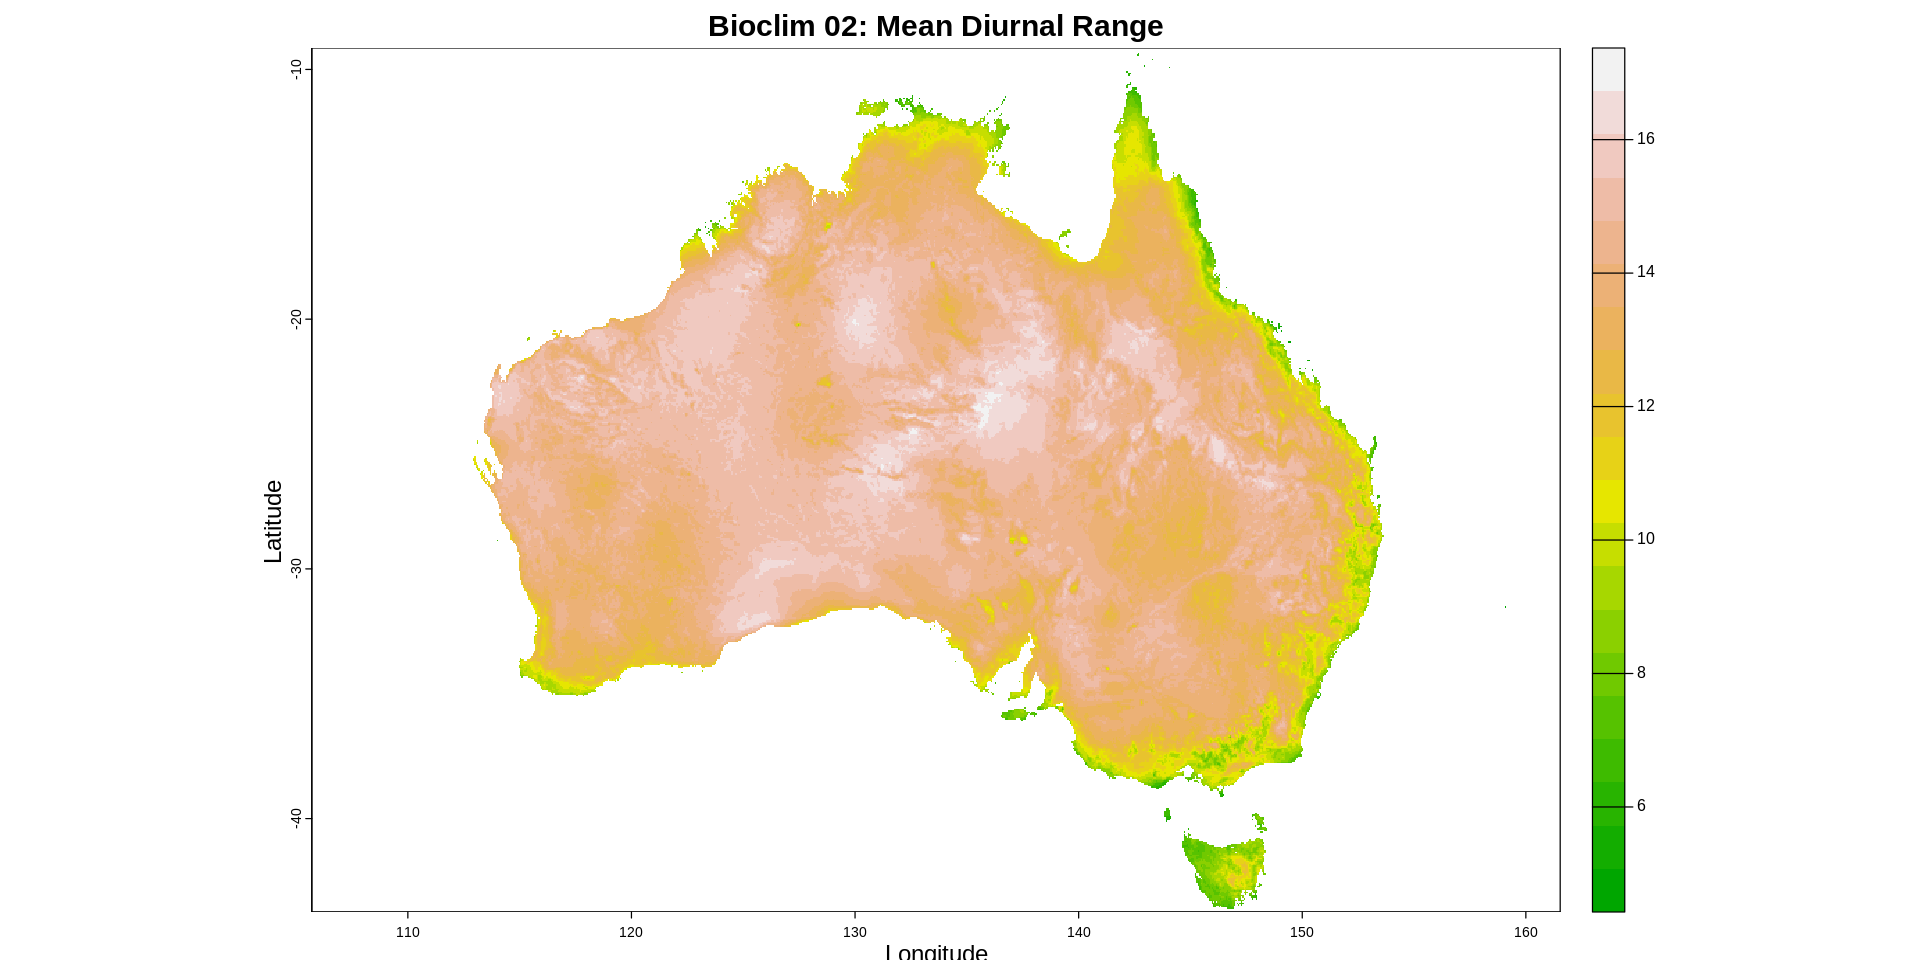

In [ ]:
# Plot the masked raster
plot(raster_stack[[2]],
     main = "Bioclim 02: Mean Diurnal Range",
     col = terrain.colors(20),
     xlab = "Longitude",
     ylab = "Latitude",
     cex.main = 1.5,
     cex.lab = 1.2,
     cex.axis = 1)


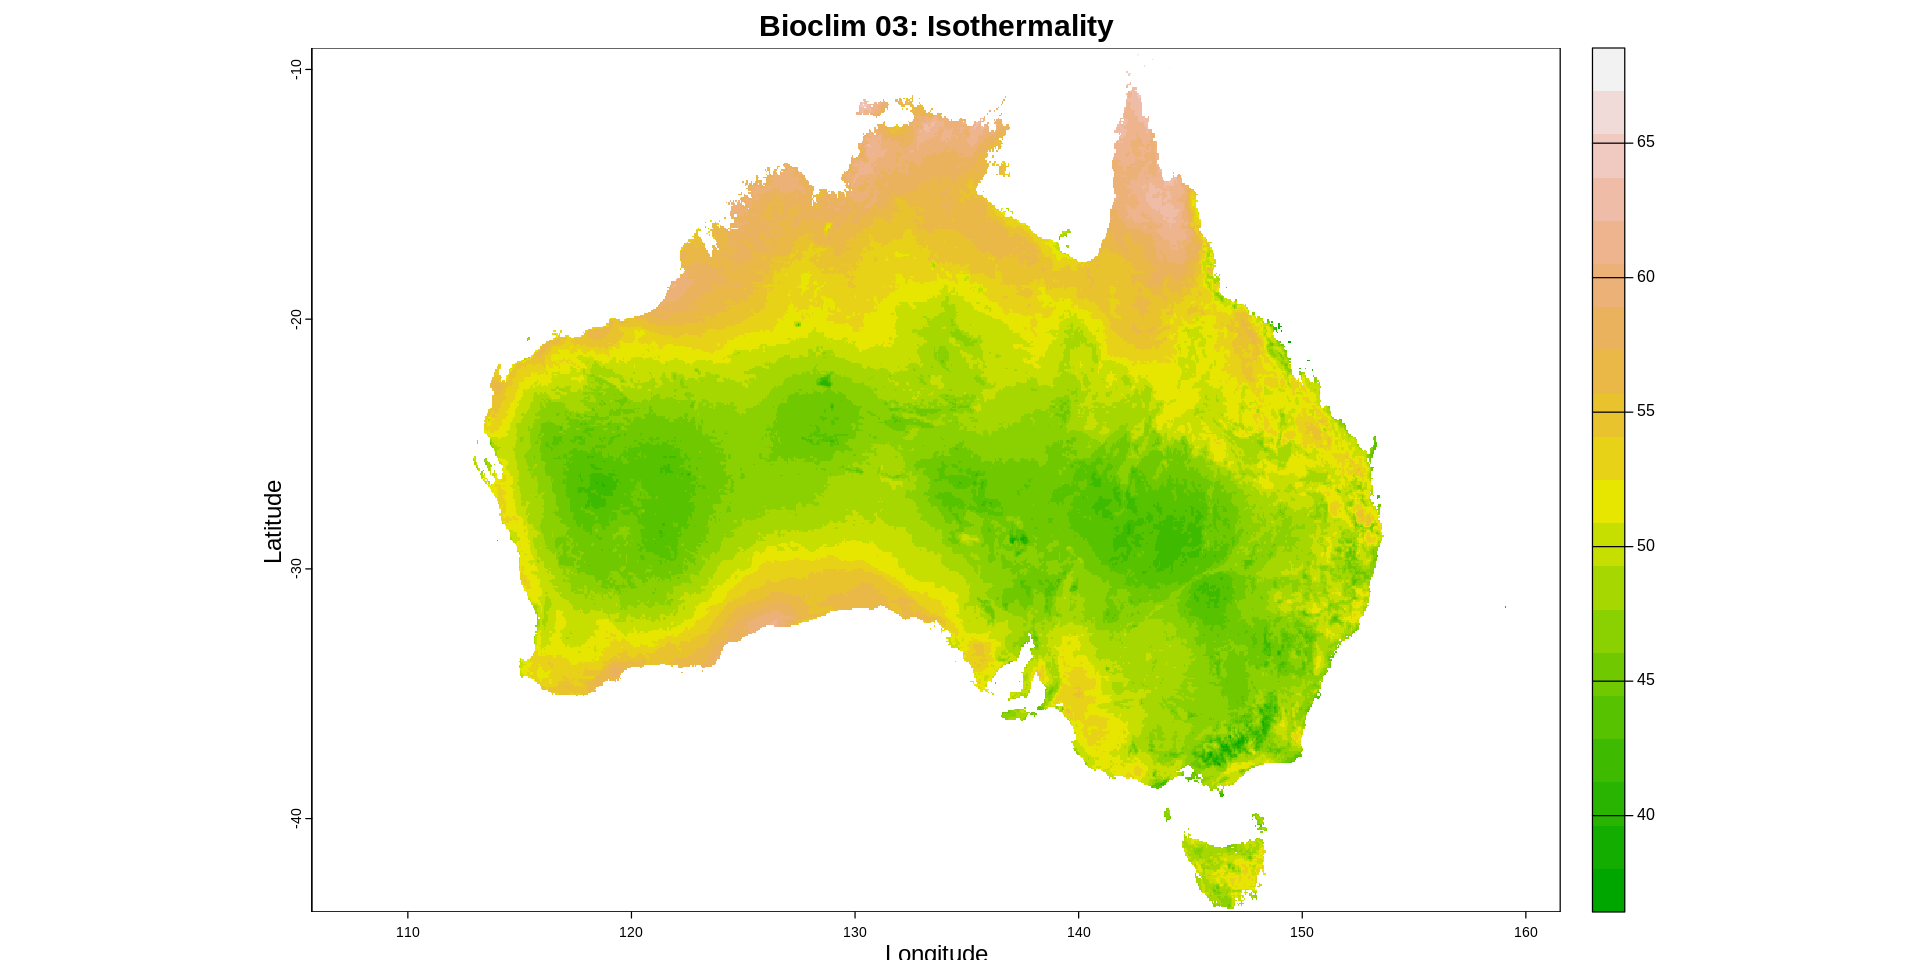

In [ ]:
# Plot the masked raster
plot(raster_stack[[3]],
     main = "Bioclim 03: Isothermality",
     col = terrain.colors(20),
     xlab = "Longitude",
     ylab = "Latitude",
     cex.main = 1.5,
     cex.lab = 1.2,
     cex.axis = 1)


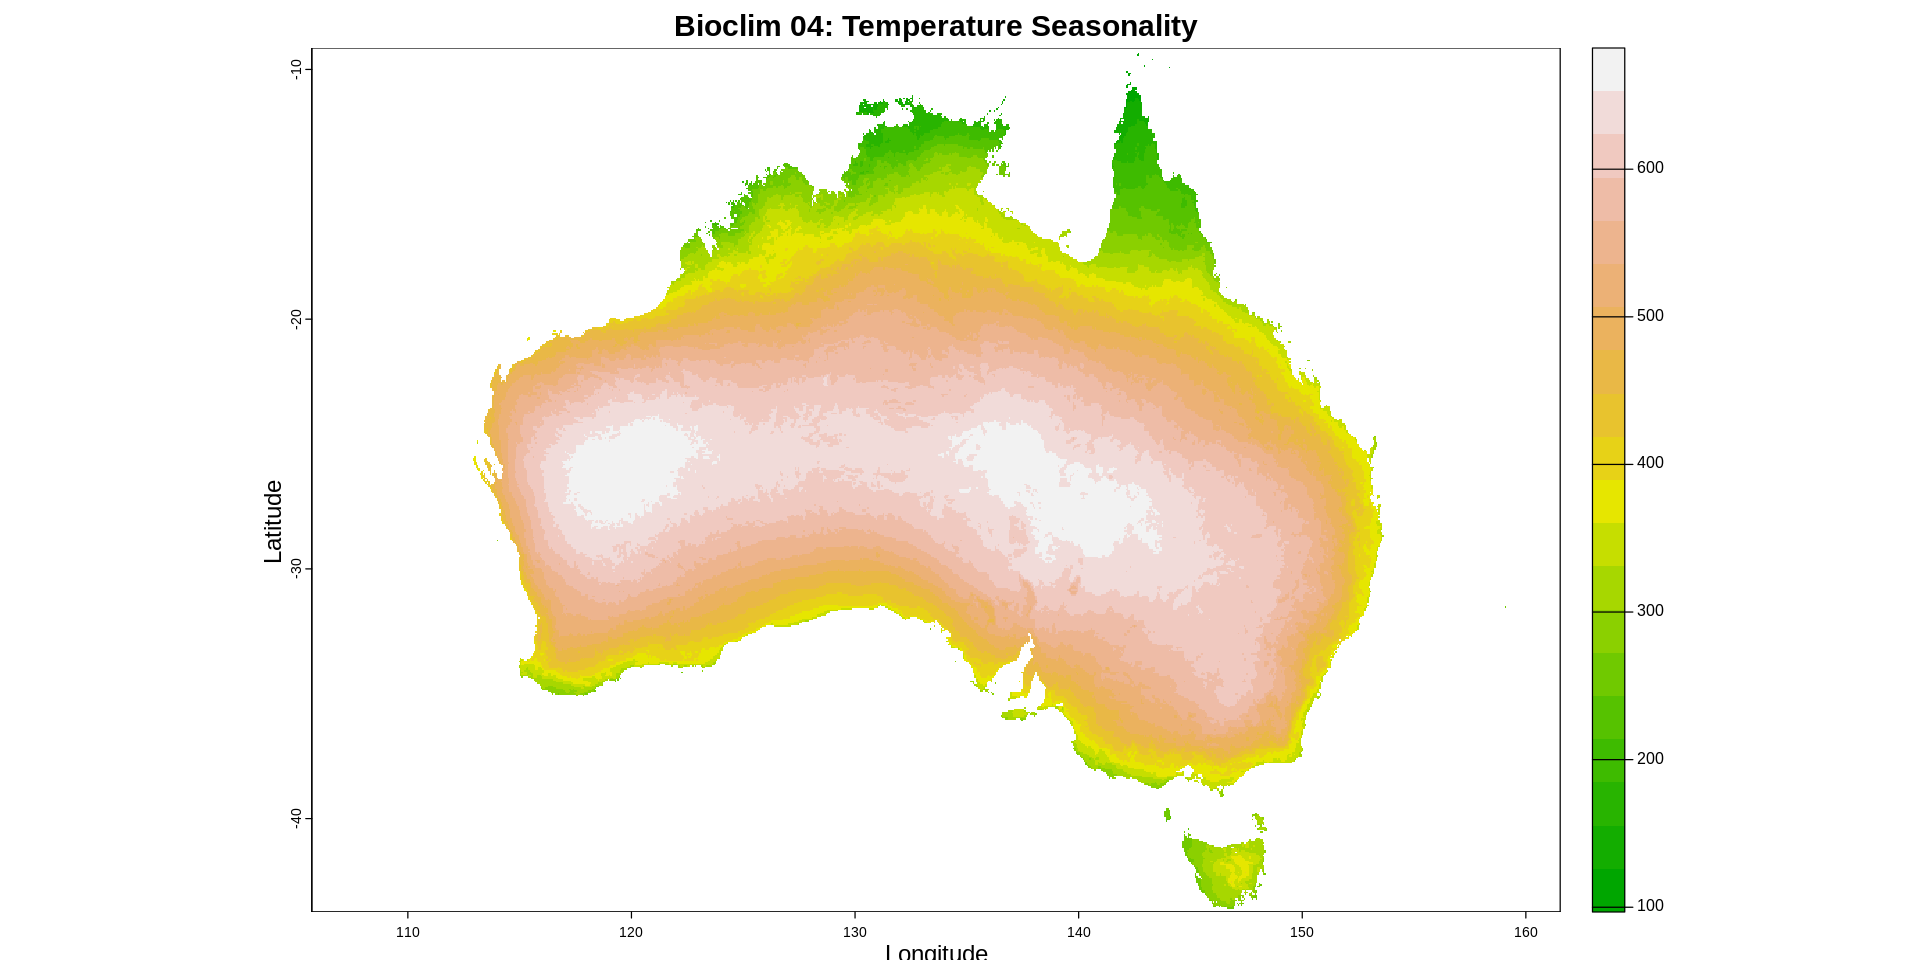

In [ ]:
# Plot the masked raster
plot(raster_stack[[4]],
     main = "Bioclim 04: Temperature Seasonality",
     col = terrain.colors(20),
     xlab = "Longitude",
     ylab = "Latitude",
     cex.main = 1.5,
     cex.lab = 1.2,
     cex.axis = 1)


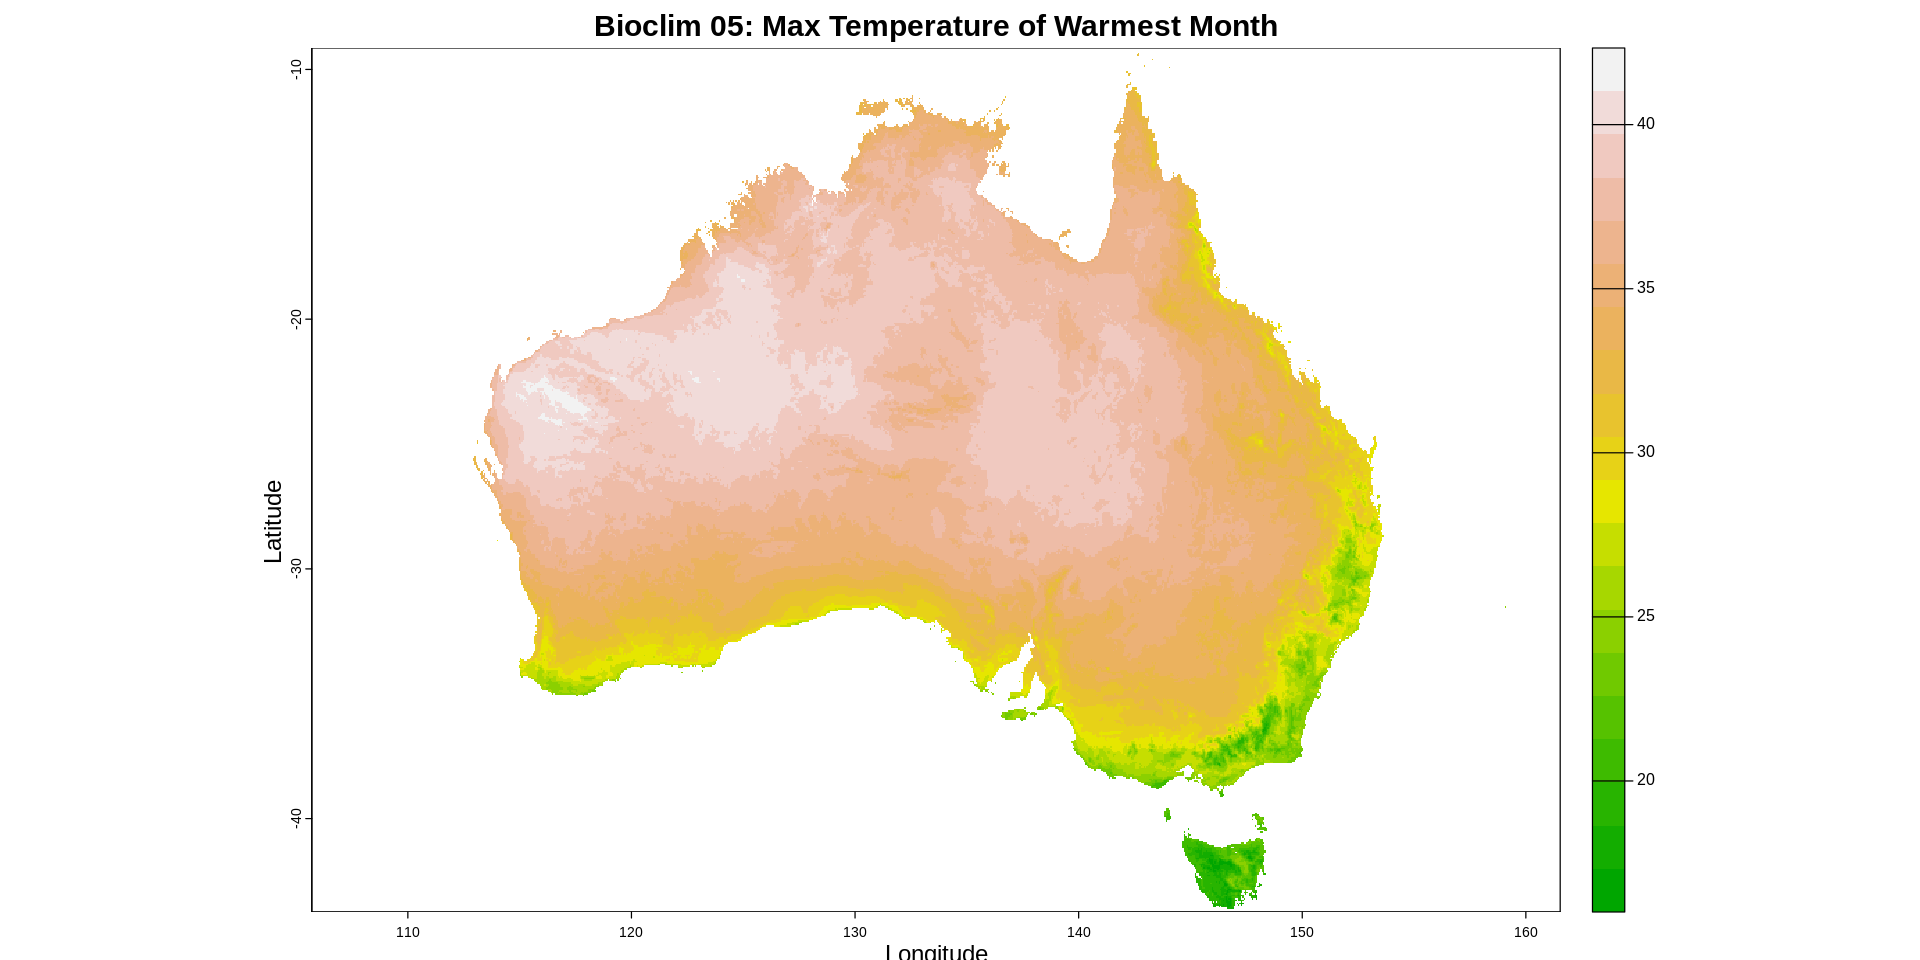

In [ ]:
# Plot the masked raster
plot(raster_stack[[5]],
     main = "Bioclim 05: Max Temperature of Warmest Month",
     col = terrain.colors(20),
     xlab = "Longitude",
     ylab = "Latitude",
     cex.main = 1.5,
     cex.lab = 1.2,
     cex.axis = 1)


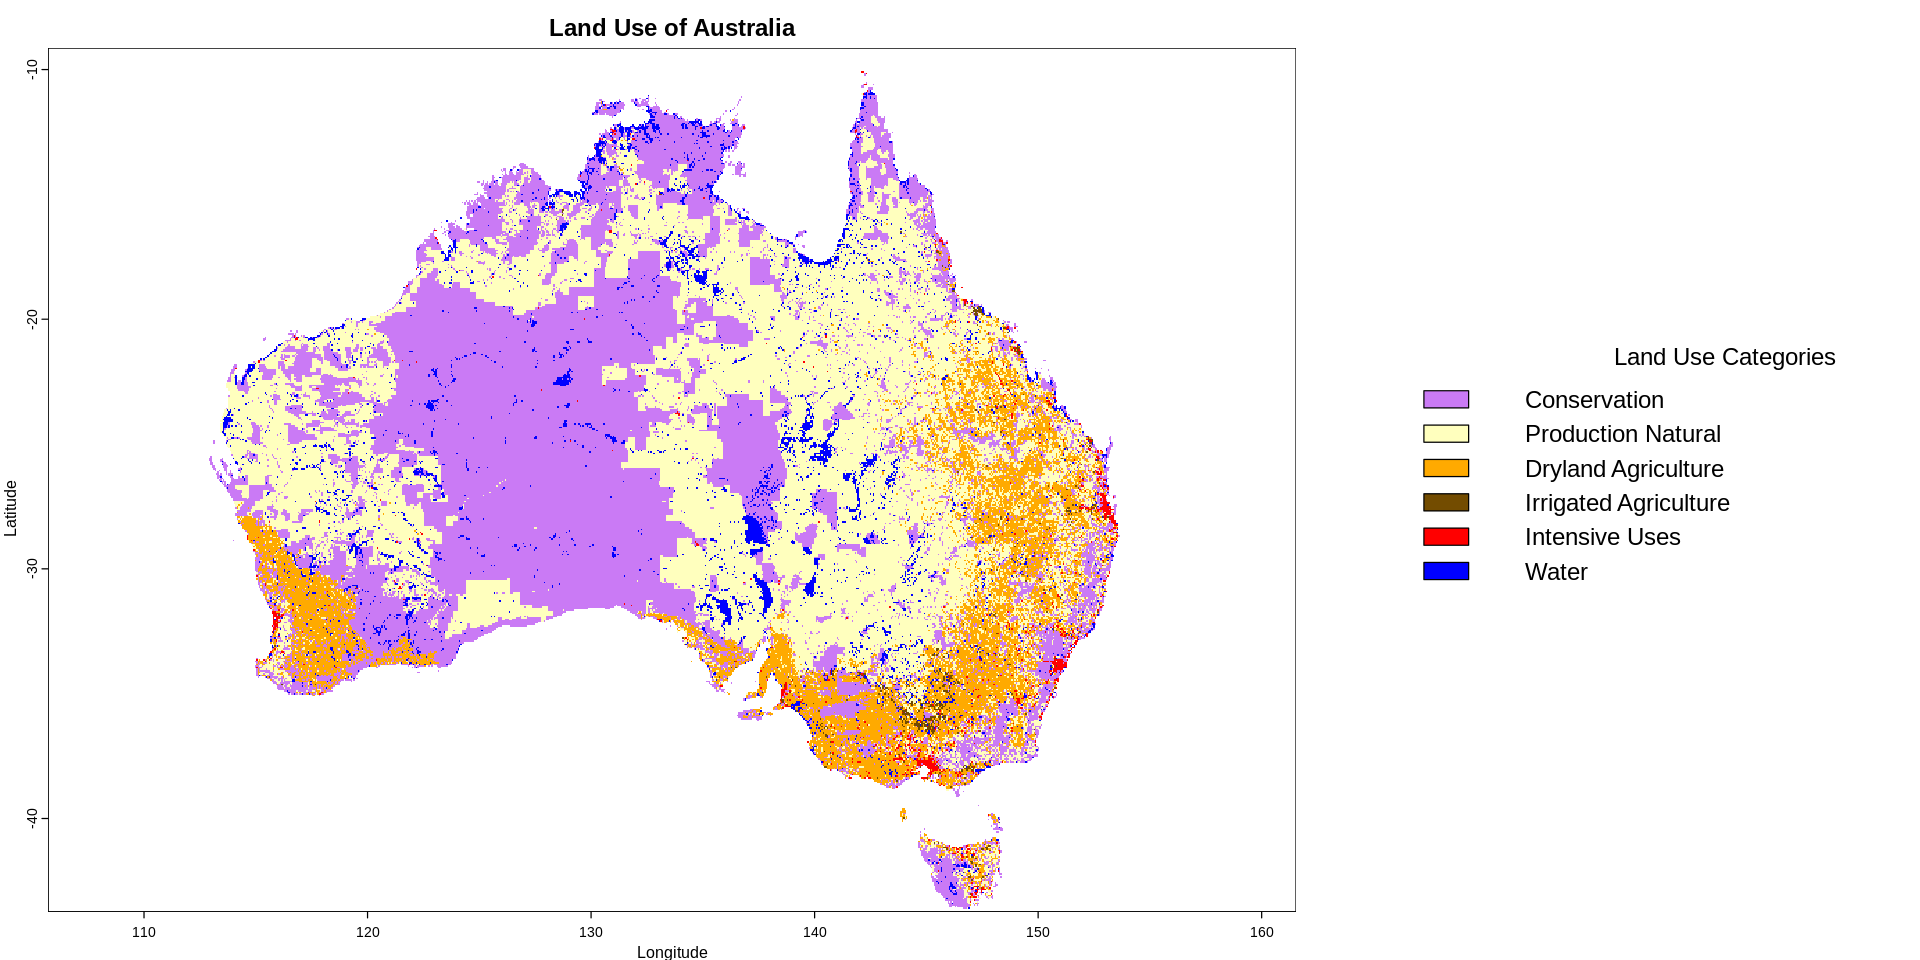

In [ ]:

# Set color palette and categories
color_palette <- c("#CA7AF5", "#FFFFBE", "#FFAA00", "#734C00", "#FF0000", "#0000FF")
color_category <- c("Conservation",
                    "Production Natural",
                    "Dryland Agriculture",
                    "Irrigated Agriculture",
                    "Intensive Uses",
                    "Water")

# Set up layout with more space for the main plot and a smaller area for the legend
layout(matrix(c(1, 2), nrow = 1), widths = c(7, 3))  # Allocate 7:3 space for the main plot and legend

# Increase the plot size by changing the options for the plot dimensions
options(repr.plot.width = 16, repr.plot.height = 8)  # This will make the plot larger in the notebook output

# Increase the margins for the main plot to make it visually balanced
par(mar = c(5, 4, 4, 1), cex.axis = 1.5, cex.lab = 1.5, cex.main = 2)  # Adjust margin and text sizes

# Plot the reclassified raster without the legend or color bar
plot(raster_stack[[6]], col = color_palette, main = "Land Use of Australia",
     legend = FALSE, axes = TRUE, xlab = "Longitude", ylab = "Latitude")

# Set margins for the legend plot area and create enough space to avoid overlap
par(mar = c(5, 1, 4, 1))  # Minimal margins for the legend area
plot.new()  # Create a blank plot for the legend

# Add a custom legend with colors and category labels, placed on the left
legend("left", legend = color_category, fill = color_palette,
       title = "Land Use Categories", cex = 1.2, bty = "n", xpd = TRUE)



## 4. Combine data for the model

In [ ]:
# For the fisrt five continuous environmental variables, we extract their values and combine them with the species presence and absence data

# Convert occurrence points to a SpatVector to work with terra package
occurrence_points <- vect(koala_sf_au)

# Initialize an empty list to store the extracted values for the first five raster layers
extracted_values_list <- list()

# Extract values for the first five environmental layers
for (i in 1:5) {
  # Extract values from the current raster layer
  extracted_values <- extract(raster_stack[[i]], occurrence_points)[, 2]  # Extracts values, removes ID column
  # Append the extracted values to the list
  extracted_values_list[[i]] <- extracted_values
}


In [ ]:

# Combine all extracted values into a dataframe
extracted_values_df <- as.data.frame(extracted_values_list)

# Set appropriate column names for the extracted environmental variables
names(extracted_values_df) <- paste0("env_var_", 1:5)

# Combine coordinates and occurrence data with the extracted values
coordinates <- st_coordinates(koala_sf_au)
occurrence_data <- as.data.frame(koala_sf_au)

# Combine all into a single dataframe
model_data_df <- data.frame(coordinates, occurrence_data, extracted_values_df)

# Rename columns for better readability
names(model_data_df)[1:2] <- c("Longitude", "Latitude")

# View the first few rows of the resulting dataframe
head(model_data_df)

,Longitude,Latitude,occurrenceStatus,geometry,env_var_1,env_var_2,env_var_3,env_var_4,env_var_5
,<dbl>,<dbl>,<fct>,<POINT [°]>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,138.7069,-34.91539,1,POINT (138.7069 -34.91539),14.54203,9.237247,45.22653,394.6680,26.39647
2,138.8452,-35.19909,1,POINT (138.8452 -35.19909),14.81205,10.868230,49.83393,393.5269,27.62096
3,138.7268,-34.91561,1,POINT (138.7268 -34.91561),13.87424,8.927568,44.39176,392.4944,25.75511
4,138.7688,-34.96979,1,POINT (138.7688 -34.96979),13.51479,9.147509,45.01126,389.9970,25.71477
5,138.6979,-34.96306,1,POINT (138.6979 -34.96306),13.86197,8.786623,44.35983,386.4311,25.53398
6,138.7317,-34.92928,1,POINT (138.7317 -34.92928),13.63266,8.823922,44.17895,390.7072,25.50289


In [ ]:
# Extract values for the sixth environmental variable
env_var_6_values <- extract(raster_stack[[6]], occurrence_points)[, 2]  # Extracts values, removes ID column

# Convert the extracted values to a factor (if not already)
env_var_6_values <- as.factor(env_var_6_values)



In [ ]:
# Add the extracted factor variable to model_data_df
model_data_df$env_cat_var_1 <- env_var_6_values

model_data_df <- na.omit(model_data_df) # we need to remove rows containing NA

# View the first few rows of the resulting dataframe
head(model_data_df)

,Longitude,Latitude,occurrenceStatus,geometry,env_var_1,env_var_2,env_var_3,env_var_4,env_var_5,env_cat_var_1
,<dbl>,<dbl>,<fct>,<POINT [°]>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,138.7069,-34.91539,1,POINT (138.7069 -34.91539),14.54203,9.237247,45.22653,394.6680,26.39647,5
2,138.8452,-35.19909,1,POINT (138.8452 -35.19909),14.81205,10.868230,49.83393,393.5269,27.62096,2
3,138.7268,-34.91561,1,POINT (138.7268 -34.91561),13.87424,8.927568,44.39176,392.4944,25.75511,2
4,138.7688,-34.96979,1,POINT (138.7688 -34.96979),13.51479,9.147509,45.01126,389.9970,25.71477,5
5,138.6979,-34.96306,1,POINT (138.6979 -34.96306),13.86197,8.786623,44.35983,386.4311,25.53398,1
6,138.7317,-34.92928,1,POINT (138.7317 -34.92928),13.63266,8.823922,44.17895,390.7072,25.50289,5


The number of absence of koala is 1958, the number of presence of koala is 242516, which is very unbalanced. We want to use oversampling method to make some pesudo absence data to add to the koala data to make 0 and 1 balanced.

Number of Additional Absence Records Needed:
242
,
516
−
1
,
958
=
240
,
558
242,516−1,958=240,558

## 5. Test Collinearity among continuous variables

Testing for collinearity among continuous variables is an important step in many modeling processes, particularly in species distribution modeling and other regression-based analyses. Collinearity occurs when two or more predictor variables in a dataset are highly correlated, which can lead to unstable estimates of regression coefficients and make it difficult to interpret the results.

There are two common methods for testing collinearity among continous variables.

Before fitting the mode, we can use **correlation matrix**

           env_var_1 env_var_2   env_var_3   env_var_4 env_var_5
env_var_1  1.0000000 0.1105075  0.57999411 -0.24165067 0.8063172
env_var_2  0.1105075 1.0000000  0.57716220  0.74838666 0.6092138
env_var_3  0.5799941 0.5771622  1.00000000 -0.07462366 0.6320608
env_var_4 -0.2416507 0.7483867 -0.07462366  1.00000000 0.2924541
env_var_5  0.8063172 0.6092138  0.63206081  0.29245415 1.0000000


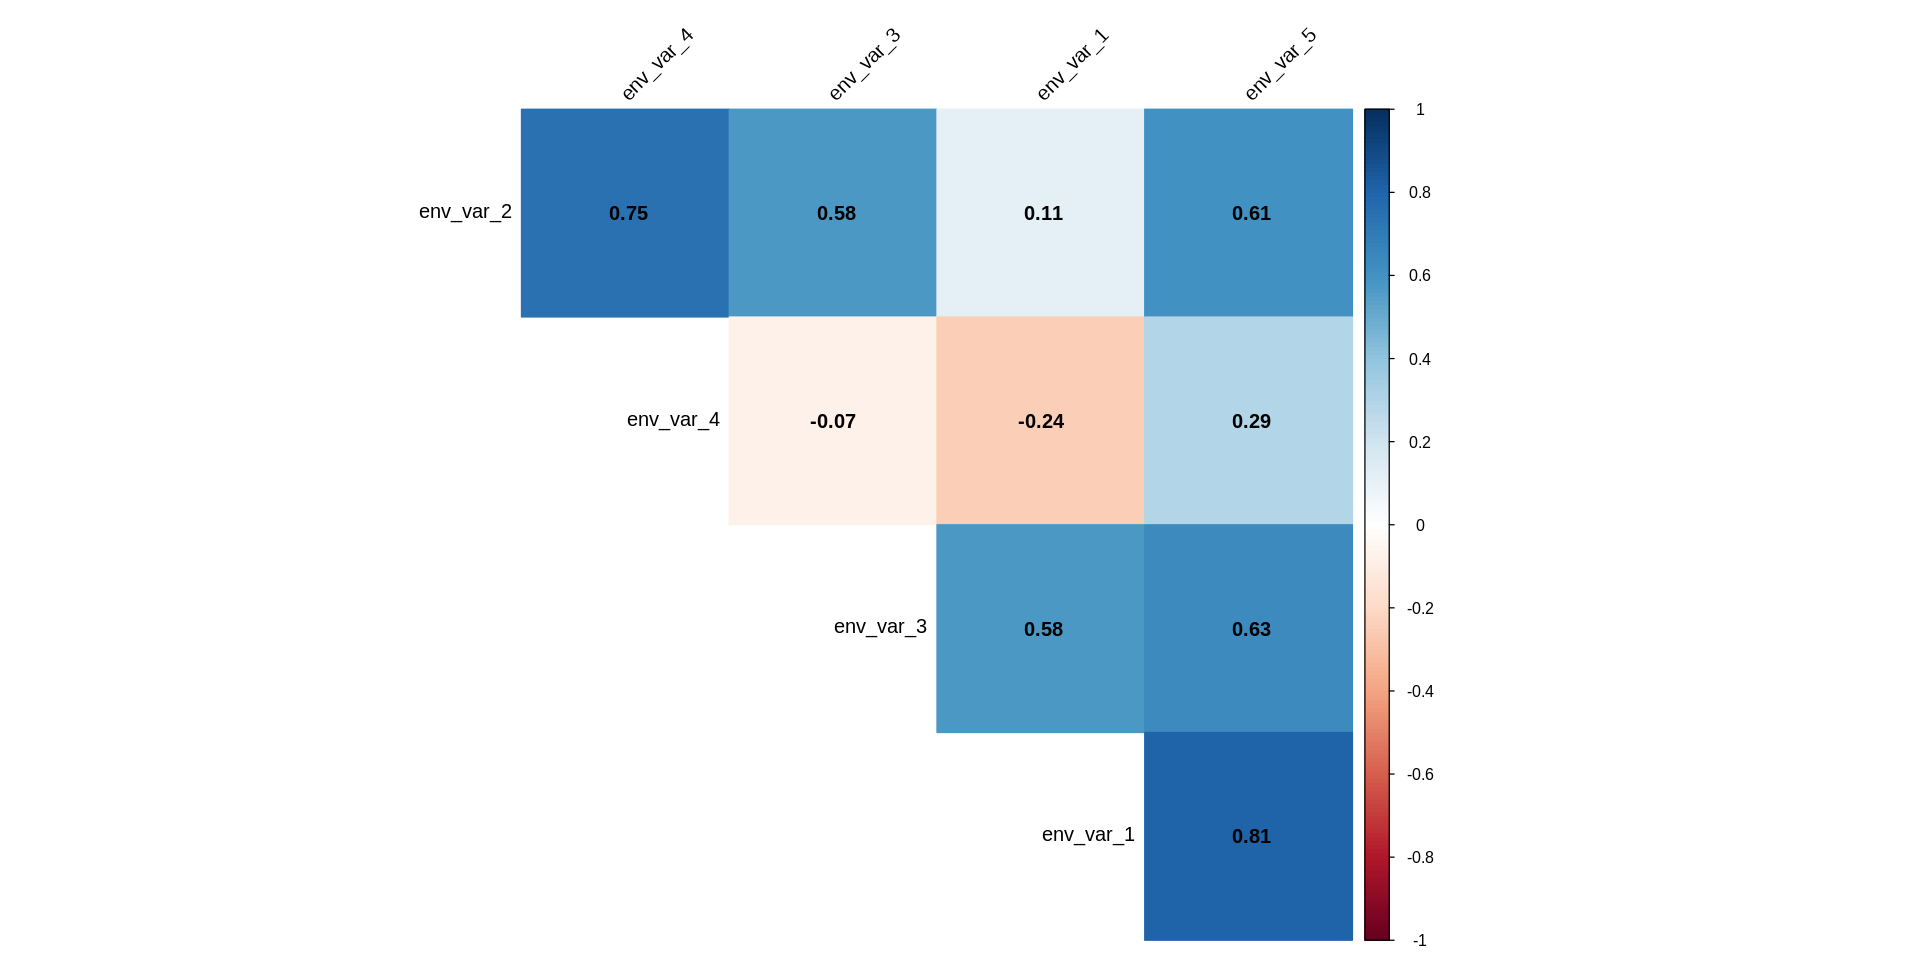

In [ ]:
# Load necessary library
library(corrplot)

# Calculate the correlation matrix for the first five continuous variables
cor_matrix <- cor(model_data_df[, c("env_var_1", "env_var_2", "env_var_3", "env_var_4", "env_var_5")],
                  use = "complete.obs", method = "pearson")
print(cor_matrix)

# Visualize the correlation matrix using corrplot
corrplot(cor_matrix,
         method = "color",          # Use colored squares to represent correlation strength
         type = "upper",            # Only show the upper triangle of the matrix
         order = "hclust",          # Reorder the variables based on hierarchical clustering
         addCoef.col = "black",     # Add correlation coefficients in black
         tl.col = "black",          # Text labels color
         tl.srt = 45,               # Rotate text labels for better readability
         diag = FALSE)              # Hide the diagonal

**From the above corrplot, we can find:**

There are some strong correlations present, notably between env_var_1 and env_var_5 (0.878) and env_var_2 and env_var_3 (0.817). This indicates potential collinearity, which could be problematic for certain modeling approaches, as it can affect the stability of model parameters.

**We don't have to include env_var_2 and env_var_5 in model anymore.**

In [ ]:
# Remove "env_var_2" and "env_var_5" by specifying their negative index
model_data_df <- model_data_df[, !names(model_data_df) %in% c("env_var_2", "env_var_5")]

In [ ]:
head(model_data_df)

,Longitude,Latitude,occurrenceStatus,geometry,env_var_1,env_var_3,env_var_4,env_cat_var_1
,<dbl>,<dbl>,<fct>,<POINT [°]>,<dbl>,<dbl>,<dbl>,<fct>
1,138.7069,-34.91539,1,POINT (138.7069 -34.91539),14.54203,45.22653,394.6680,5
2,138.8452,-35.19909,1,POINT (138.8452 -35.19909),14.81205,49.83393,393.5269,2
3,138.7268,-34.91561,1,POINT (138.7268 -34.91561),13.87424,44.39176,392.4944,2
4,138.7688,-34.96979,1,POINT (138.7688 -34.96979),13.51479,45.01126,389.9970,5
5,138.6979,-34.96306,1,POINT (138.6979 -34.96306),13.86197,44.35983,386.4311,1
6,138.7317,-34.92928,1,POINT (138.7317 -34.92928),13.63266,44.17895,390.7072,5


## 6. Dealing with unbalanced dataset

Since our koala absences are too few comparing with the presences, we need to use resamping tehniques to increase the koala absences in the datasets to make it even.

In [ ]:
# Calculate counts for presence and absence
print(koala_counts)

Simple feature collection with 2 features and 2 fields
Geometry type: MULTIPOINT
Dimension:     XY
Bounding box:  xmin: 115.6839 ymin: -39.1295 xmax: 154 ymax: -15.4
Geodetic CRS:  WGS 84
  occurrenceStatus      n                       geometry
1                0   1958 MULTIPOINT ((146.8646 -19.1...
2                1 242516 MULTIPOINT ((135 -31), (134...


In [ ]:
# we can use R package called "ROSE" to do the oversampling

install.packages("ROSE")
library(ROSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Balance the dataset using oversampling for absences
balanced_data <- ovun.sample(
  occurrenceStatus ~ env_var_1 + env_var_3 + env_var_4 + env_cat_var_1,
  data = model_data_df,
  method = "over",
  N = 2 * 242516  # Total desired sample size: equal number of 0 and 1
)$data

# Verify the balance of the dataset
table(balanced_data$occurrenceStatus)



     1      0 
242148 242884 

Now, our 0s and 1s look very even.

## 7. Split data into training dataset (80%) and testing dataset (20%)


In [ ]:

## 80% of the species occurrence data
smp_size <- floor(0.8 * nrow(balanced_data))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(balanced_data)), size = smp_size)

training_df <- balanced_data[train_ind, ]
testing_df <- balanced_data[-train_ind, ]

# C. Generalised Logistic Regression (GLM)

## 1. Model Configuration

We are fitting a logistic regression model using 3 continous environmental variables and one categorical variable as predictors with the **testing dataset**.

In [ ]:
# Let's make a null model as a benchmark

# Fit a null model with only the intercept
null_model <- glm(occurrenceStatus ~ 1,
                  data = training_df,
                  family = binomial(link = "logit"))

summary(null_model)


Call:
glm(formula = occurrenceStatus ~ 1, family = binomial(link = "logit"), 
    data = training_df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept) 0.002232   0.003211   0.695    0.487

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 537916  on 388024  degrees of freedom
Residual deviance: 537916  on 388024  degrees of freedom
AIC: 537918

Number of Fisher Scoring iterations: 3


In [ ]:
# Fit a logistic regression model with presence (binary response)
glm_model <- glm(occurrenceStatus ~ env_var_1 + env_var_3 + env_var_4 + env_cat_var_1,
                 data = training_df,
                 family = binomial(link = "logit")) #in the Generalized Linear Model (GLM), setting family = binomial(link = "logit") is appropriate when dealing with binary outcomes such as presence (1) and absence (0) of an event, which, in this case, is the occurrence of tree kangaroos.

# Summary of the model to view the results
summary(glm_model)


Call:
glm(formula = occurrenceStatus ~ env_var_1 + env_var_3 + env_var_4 + 
    env_cat_var_1, family = binomial(link = "logit"), data = training_df)

Coefficients:
                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)     2.227e+01  1.023e-01  217.625  < 2e-16 ***
env_var_1      -1.453e-01  2.273e-03  -63.914  < 2e-16 ***
env_var_3      -4.154e-01  2.454e-03 -169.263  < 2e-16 ***
env_var_4      -6.919e-04  9.812e-05   -7.052 1.76e-12 ***
env_cat_var_12 -2.999e-01  1.638e-02  -18.314  < 2e-16 ***
env_cat_var_13  1.483e+00  1.948e-02   76.106  < 2e-16 ***
env_cat_var_14  1.737e+00  5.866e-02   29.615  < 2e-16 ***
env_cat_var_15  3.009e-01  9.339e-03   32.216  < 2e-16 ***
env_cat_var_16 -8.016e-02  2.501e-02   -3.206  0.00135 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 537916  on 388024  degrees of freedom
Residual deviance: 403314  on 388016  degrees of freedom
AIC:

In [ ]:
# Let's compare the performance of our model to a null model

# Compare null model with full model using the analysis of deviance (Likelihood Ratio Test)
anova(null_model, glm_model, test = "Chisq")

# Compare the AIC of the null model and the full model
AIC(null_model, glm_model)

# Get the null deviance and residual deviance from the full model
null_deviance <- glm_model$null.deviance
residual_deviance <- glm_model$deviance

# Calculate the deviance explained
deviance_explained <- (null_deviance - residual_deviance) / null_deviance

# Print the deviance explained as a percentage
deviance_explained_percent <- deviance_explained * 100
cat("Deviance Explained:", deviance_explained_percent, "%\n")



,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,388024,537916.4,NA,NA,NA
2,388016,403314.4,8,134602,0


,df,AIC
,<dbl>,<dbl>
null_model,1,537918.4
glm_model,9,403332.4


Deviance Explained: 25.02285 %


### Summary of Interpretation

The **Likelihood Ratio Test (ANOVA)** shows that adding the predictors significantly improved the model's fit compared to the null model, as indicated by the high deviance reduction and a p-value of 0.

The **AIC** for the full model is much lower than the null model, further indicating a better fit when balancing model complexity.

The **Deviance Explained** of 25.34% suggests that the full model explains about a quarter of the variability in koala presence/absence, indicating that while the predictors contribute useful information, there is still substantial unexplained variability that may require further investigation or additional predictors.


## 2. Model evaluation

Now, we use the **testing dataset** to evaluate the model performance.

Setting levels: control = 1, case = 0

Setting direction: controls < cases



Area under the curve: 0.8372


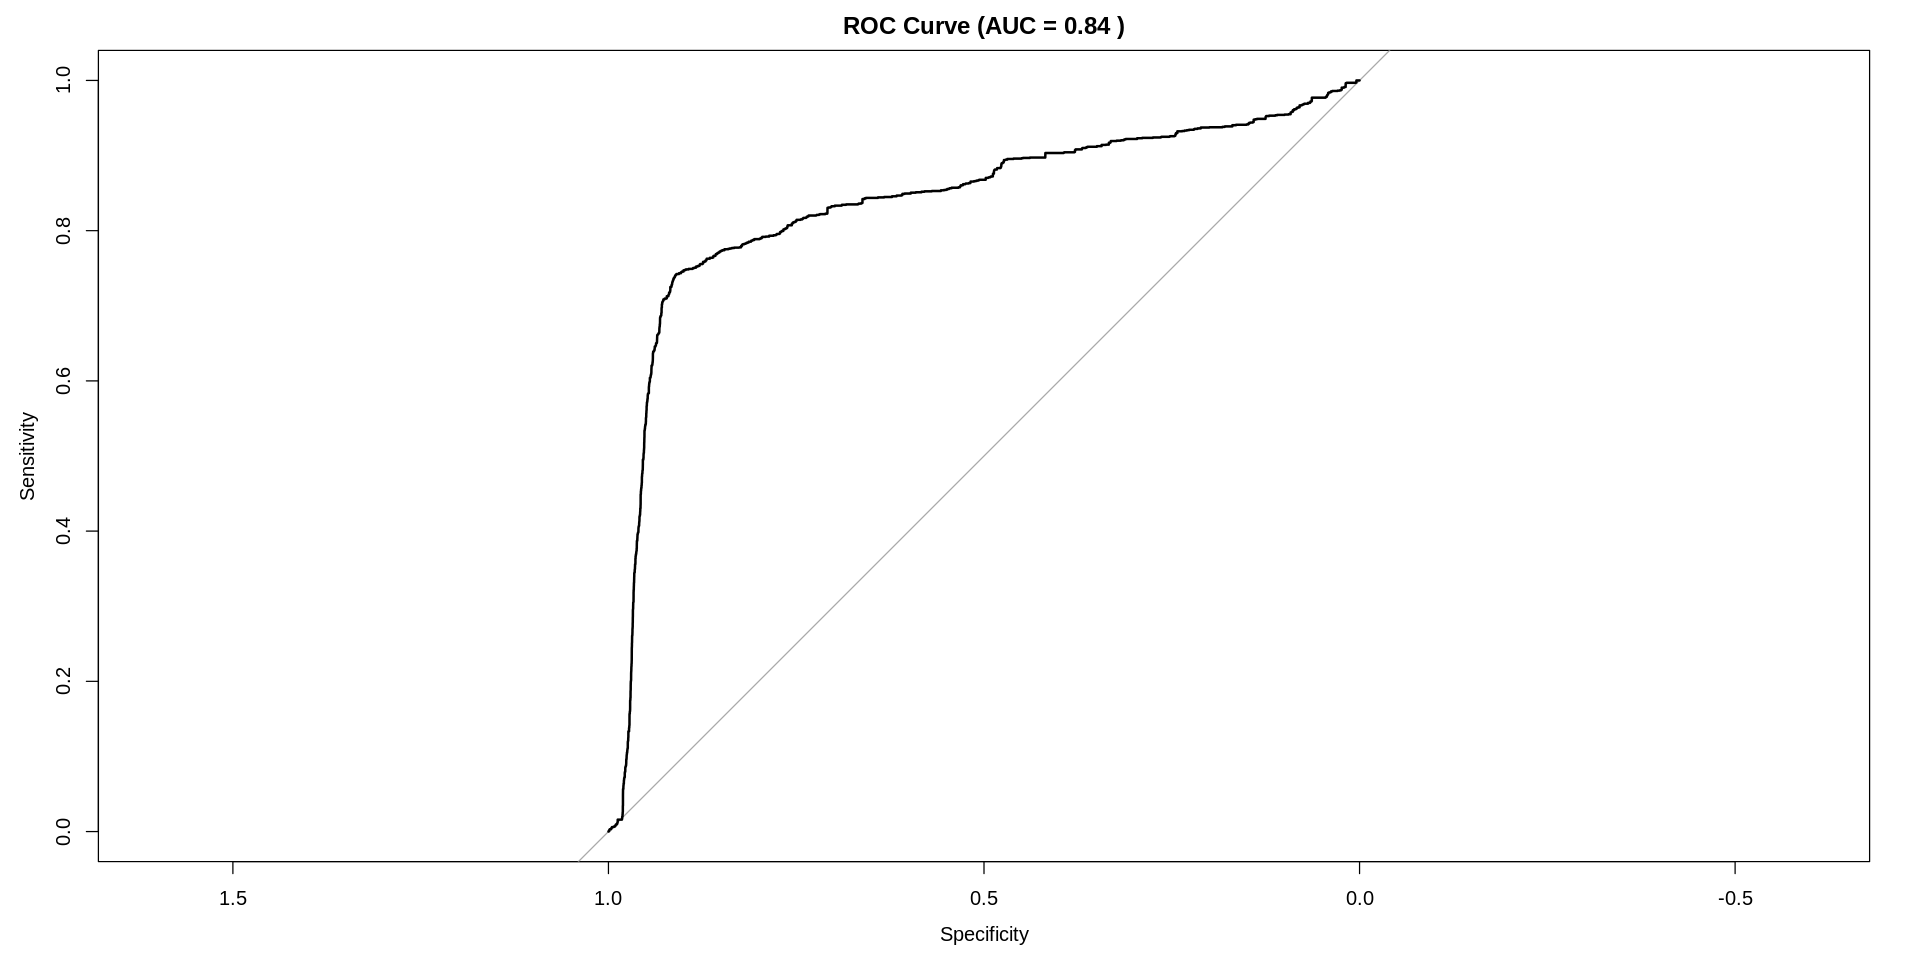

In [ ]:
# Predict on the testing data
predicted_probs <- predict(glm_model, newdata = testing_df, type = "response")

# Convert probabilities to binary predictions (using a threshold of 0.5)
predicted_classes <- ifelse(predicted_probs > 0.5, 1, 0)

library(pROC)

# Create an ROC curve and compute AUC
roc_curve <- roc(testing_df$occurrenceStatus, predicted_probs)
auc_value <- auc(roc_curve)
print(auc_value)

# Plot the ROC curve
plot(roc_curve, main = paste("ROC Curve (AUC =", round(auc_value, 2), ")"))


# D. Predictions
## 1. Predictions on Current Environment

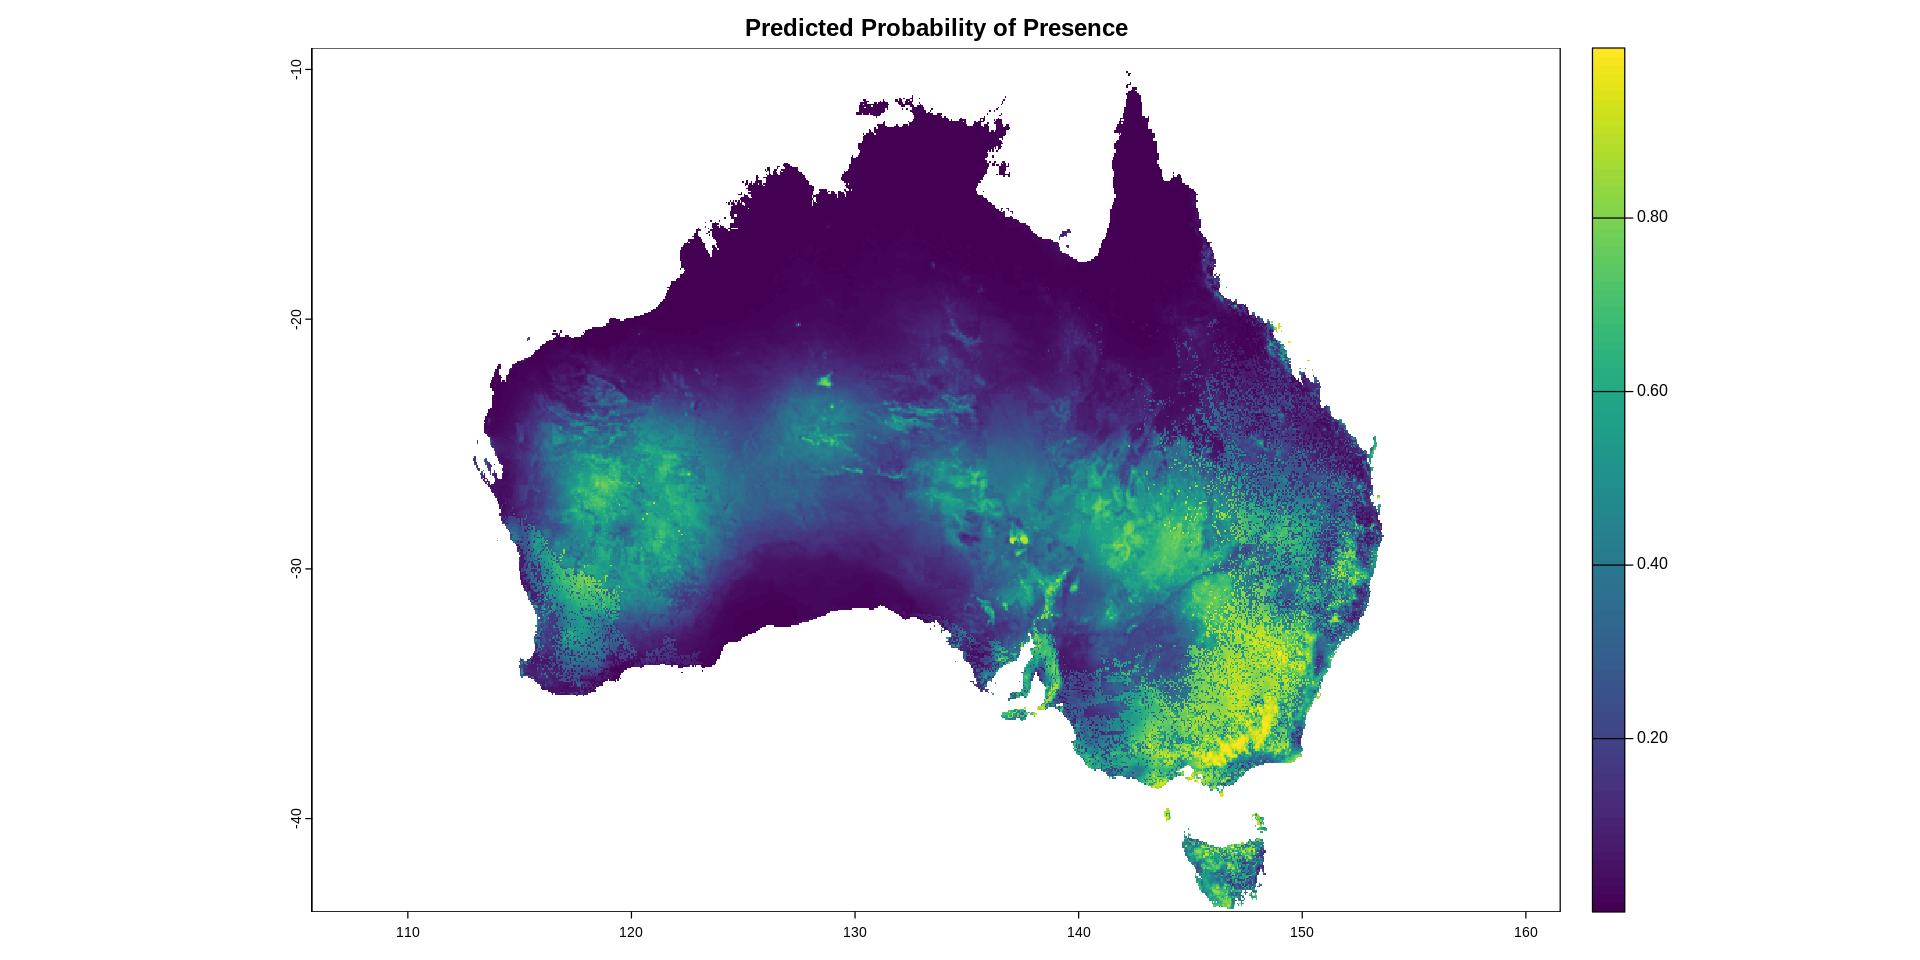

In [ ]:
# Predict the presence probability across the entire raster extent
predicted_raster <- predict(raster_stack, glm_model, type = "response")

# Plot the predicted raster to visualize the results
plot(predicted_raster, main = "Predicted Probability of Presence")

![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/EC_section_break.png)


EcoCommons Australia partners with the Australian Research Data Commons (ARDC), which is supported by funding from the National Collaborative Research Infrastructure Strategy (NCRIS) [https://doi.org/10.47486/PL108. ](https://doi.org/10.47486/PL108)

<div align="center">

<br><br>

**Our partner**

</div>

![](https://raw.githubusercontent.com/EcoCommons-Australia-2024-2026/ec-notebook_site/main/images/partners_logos.png)

### **How to Cite EcoCommons**

If you use EcoCommons in your research, please cite the platform as follows:

> EcoCommons Australia 2024. *EcoCommons Australia – a collaborative commons for ecological and environmental modelling*, Queensland Cyber Infrastructure Foundation, Brisbane, Queensland. Available at: <https://data–explorer.app.ecocommons.org.au/> (Accessed: MM DD, YYYY). https://doi.org/10.47486/PL108

You can download the citation file for EcoCommons Australia here: [Download the BibTeX file](reference.bib)